In [4]:
from CTRModules import *

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader

from torchmetrics.classification import AUROC

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import gc

import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "F:/CTR_Prediction/data/"

X_train = pd.read_csv(DATA_PATH + "X_train.csv")
X_val = pd.read_csv(DATA_PATH + "X_val.csv")
y_train = pd.read_csv(DATA_PATH + "y_train.csv")
y_val = pd.read_csv(DATA_PATH + "y_val.csv")

In [3]:
X_train_seq =  X_train.pop("seq")
X_val_seq = X_val.pop("seq")

In [8]:
X_val_seq

0          9,57,516,74,527,318,77,138,101,532,132,101,101...
1          144,9,57,516,505,551,516,527,74,77,318,317,306...
2          9,269,57,516,479,27,57,516,527,74,77,132,138,1...
3          101,57,516,527,74,463,193,212,74,318,77,207,45...
4          57,463,212,193,470,269,151,463,151,331,269,470...
                                 ...                        
2140831    144,9,18,57,516,165,97,338,416,479,35,269,516,...
2140832    9,269,57,516,527,74,77,318,317,311,479,269,57,...
2140833    57,516,527,74,318,77,463,193,212,74,77,317,58,...
2140834    144,269,57,516,97,527,74,77,318,463,193,212,15...
2140835    144,546,546,57,463,212,193,151,151,331,269,470...
Name: seq, Length: 2140836, dtype: object

In [20]:
L = []

for seq in X_val_seq:
    arr = np.fromstring(seq, sep=",", dtype=np.float32)
    L.append(max(arr))

L

[np.float32(544.0),
 np.float32(551.0),
 np.float32(577.0),
 np.float32(577.0),
 np.float32(479.0),
 np.float32(540.0),
 np.float32(544.0),
 np.float32(545.0),
 np.float32(544.0),
 np.float32(516.0),
 np.float32(545.0),
 np.float32(516.0),
 np.float32(544.0),
 np.float32(540.0),
 np.float32(544.0),
 np.float32(544.0),
 np.float32(551.0),
 np.float32(577.0),
 np.float32(527.0),
 np.float32(577.0),
 np.float32(561.0),
 np.float32(551.0),
 np.float32(551.0),
 np.float32(479.0),
 np.float32(544.0),
 np.float32(540.0),
 np.float32(551.0),
 np.float32(544.0),
 np.float32(527.0),
 np.float32(577.0),
 np.float32(577.0),
 np.float32(551.0),
 np.float32(516.0),
 np.float32(545.0),
 np.float32(561.0),
 np.float32(577.0),
 np.float32(516.0),
 np.float32(544.0),
 np.float32(540.0),
 np.float32(577.0),
 np.float32(544.0),
 np.float32(527.0),
 np.float32(577.0),
 np.float32(577.0),
 np.float32(516.0),
 np.float32(577.0),
 np.float32(577.0),
 np.float32(516.0),
 np.float32(527.0),
 np.float32(516.0),


In [21]:
max(L)

np.float32(594.0)

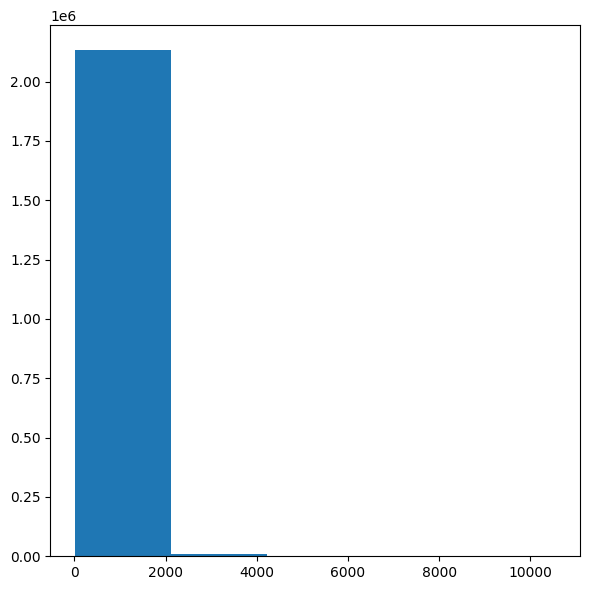

In [19]:
plt.figure(figsize=(6,6))
plt.hist(L, bins=5)
plt.tight_layout()
plt.show()

In [ ]:
BATCH_SIZE = 64

trainDS = CTRDataset(X_train, X_train_seq, y_train)
valDS = CTRDataset(X_val, X_val_seq, y_val)

trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_train)
valDL = DataLoader(valDS, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_train)

In [ ]:
EPOCH = 300
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3

hidden_dim = [1024, 512, 256, 128]

num_embeddings = 600 + 1
transformer_dim = 64
nhead = 4
num_encoder_layers = 2

model = DCNv2(input_dim=X_train.shape[1],
              num_layers=2,
              hidden_dim=hidden_dim,
              dropout=0.2,
              num_embeddings=num_embeddings,
              transformer_dim=transformer_dim,
              nhead=nhead,
              num_encoder_layers=num_encoder_layers
              ).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LR)

weight = torch.tensor([98 / 2])

loss_fn = nn.BCELoss(weight=weight).to(DEVICE)
score_fn = AUROC(task="binary")

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5)

data_size = len(X_train)
val_data_size = len(X_val)

In [ ]:
del X_train, X_train_seq, X_val, X_val_seq, y_train, y_val

gc.collect()
torch.cuda.empty_cache()

In [ ]:
loss, score = training(model, trainDL, valDL, optimizer, EPOCH,
                       data_size, val_data_size, loss_fn, score_fn, 
                       scheduler, DEVICE)

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.60 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 17.85 GiB is allocated by PyTorch, and 2.02 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
testDS = CTRDataset(test)

testDL = DataLoader(testDS, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model.eval()
output = []

with torch.no_grad():
    for test_features in testDL:
        test_features = test_features.to(DEVICE)
        output.append(model(test_features).cpu())

test_preds = torch.cat(output).numpy()

In [ ]:
print(test_preds[:10])

In [ ]:
SUBMISSION_PATH = "./data/sample_submission.csv"

submission_df = pd.read_csv(SUBMISSION_PATH)

submission_df["clicked"] = test_preds


In [ ]:
submission_df.to_csv("./data/DCNv2_submission.csv", index=False)